<h2>IMDB Sentiment Prediction LSTM</h2>

In [4]:
import os

In [5]:
os.chdir("/content/drive/My Drive/Python/Practice/IMDB Review")

In [6]:
ls

 Duplicate/         'IMDB Sentiment Analysis'   tokenizer_imdb.pickle
'IMDB Dataset.csv'   models/


<h3>Importing the required library's</h3>

In [49]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint  
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
df = pd.read_csv("IMDB Dataset.csv")

In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<h3>Encoder and Decoder</h3>

In [13]:
def encode_sentiment(sentiment) -> int:
  encoder = {"positive" : 1 , "negative": 0 ,"Positive":1 , "Negative" : 0}
  if sentiment!=None:
    return encoder[sentiment]

In [14]:
def decode_sentiment(sentiment) -> str:
  decoder = {1: "positive" , 0: "negative"}
  if sentiment!=None:
    return decoder[sentiment]

<h3>Applying the encoder to the 'new_sentiment' column</h3>

In [15]:
train_df = df

In [16]:
train_df['new_sentiment'] = train_df['sentiment'].apply(encode_sentiment)

<h3>Shuffling the data</h3>

In [17]:
train_df = train_df.sample(frac=1)

<h3>Preprocessing the text</h3>

*   Converting the string to lower case

*   Removing any html tags

*   Removing any special characters

*   Removing stop words





In [18]:
def process_text(text) -> str:
  #Convert string 
  process_text = str(text)
  #Convert string to lower
  process_text = process_text.lower()
  #Removing html tags
  process_text = re.sub("<.*?>"," ",process_text)
  #Removing all digits and having only letters
  process_text = re.sub("[^a-zA-Z]"," ",process_text)
  #Removing all stop words
  process_text = process_text.split(" ")
  process_text = " ".join([word for word in process_text if word not in stopwords.words("english")])

  return process_text

In [19]:
tqdm.pandas()

In [21]:
train_df['processed_text'] = train_df['review'].progress_apply(process_text)

100%|██████████| 50000/50000 [23:48<00:00, 35.00it/s]


In [22]:
positive_sentiment = train_df.loc[train_df['new_sentiment']==1]
negative_sentiment = train_df.loc[train_df['new_sentiment']==0]

In [53]:
positive_sentiment.head()

,review,sentiment,new_sentiment,processed_text
7131,I've just seen this movie in a preview and I c...,positive,1,seen movie preview recommend watch minutes...
25474,The time is the future and for many not aware ...,positive,1,time future many aware day final movie legen...
14544,This documentary is as unique as it's subject....,positive,1,documentary unique subject amato staple eroti...
32581,"This is a superb TV series, it's sympathetic a...",positive,1,superb tv series sympathetic realistic portr...
14690,Straight from the brilliant mind of animation ...,positive,1,straight brilliant mind animation pioneer wlad...


<h3>Word Cloud</h3>

In [23]:
positive_string = ' '.join([word for word in positive_sentiment['processed_text'].values])
# Display the generated image:
wordcloud = WordCloud().generate(positive_string)

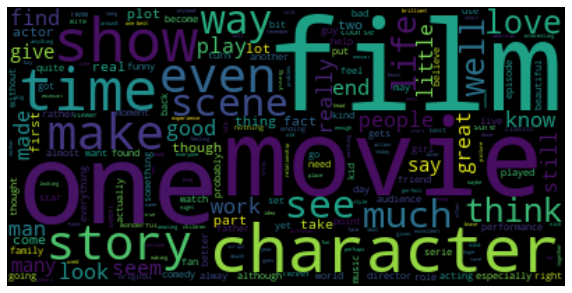

In [24]:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
negative_string = ' '.join([word for word in negative_sentiment['processed_text'].values])
# Display the generated image:
negative = WordCloud().generate(negative_string)

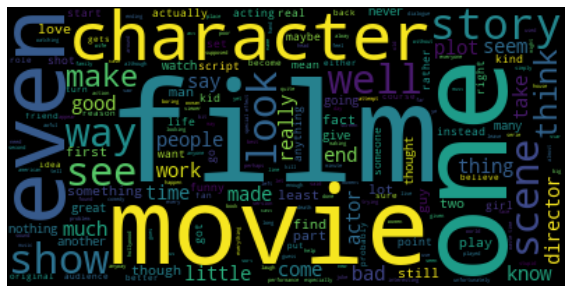

In [26]:
plt.figure(figsize=(10,8))
plt.imshow(negative, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
train = train_df[['processed_text','new_sentiment']]

In [28]:
train.to_csv("processed_text")

In [35]:
text = train['processed_text'].values
sentiment = train['new_sentiment'].values

<h3>Tokenizer</h3>

In [92]:
tokenizer = Tokenizer()

In [93]:
tokenizer.fit_on_texts(text)

<h4>Saving tokenizer for web application</h4>

In [30]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
print("Vocab size : {} ".format(len(tokenizer.word_index)+1))

Vocab size : 99268 


<h3>Converting the text to sequence of integers</h3>

In [36]:
sequence_text = tokenizer.texts_to_sequences(text)

In [37]:
sequence_text = pad_sequences(sequence_text,padding="post")

In [45]:
x_train , x_test , y_train ,y_test = train_test_split(sequence_text,sentiment,
                                                      test_size=0.3,random_state=11)

In [104]:
print(f"""
X Train :{x_train.shape}
X TEST : {x_test.shape}
Y TRAIN : {y_train.shape}
Y TEST  : {y_test.shape}
""")


X Train :(35000, 1422)
X TEST : (15000, 1422)
Y TRAIN : (35000,)
Y TEST  : (15000,)



<h3>Building & Compiling the model</h3>

In [98]:
VOCAB_SIZE = len(tokenizer.word_index)+1
EMBEDDING_VEC = 30

In [157]:
def create_model(lstm_unit):
    model = tf.keras.Sequential([
    L.Embedding(VOCAB_SIZE,EMBEDDING_VEC, input_length=x_train.shape[1]),
    L.Bidirectional(L.LSTM(lstm_unit,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(lstm_unit, activation="relu"),
    L.Dropout(0.4),
    L.Dense(2)
    ])
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )
    return model

In [39]:
LSTM_UNIT = [128,256] #Add more if needed

In [ ]:
for unit in LSTM_UNIT:
  create_checkpoint = ModelCheckpoint(f'models/LSTM-{unit}-{datetime.timestamp(datetime.now())}.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
  )
  create_model = create_model(unit)
  print(f"Training for : {unit} units")
  print("Model summary")
  print(create_model.summary())
  print("="*100)
  model.fit(x_train,y_train , validation_data=(x_test,y_test),batch_size=32
          ,epochs=2,callbacks=[create_checkpoint])

<h3>Loading the model & Making predictions</h3>

In [41]:
model = load_model('models/LSTM-128-1603243938.238329.h5')

In [46]:
prediction = model.predict_classes(x_test)

In [47]:
print("Accuracy score of the model : {} %" .format(accuracy_score(y_test,prediction)*100))

Accuracy score of the model : 95.81333333333333 %


<h3>Confusion Matrix</h3>

In [48]:
print(confusion_matrix(y_test,prediction))

[[7153  310]
 [ 318 7219]]


As we can see our model has a good sense of predicting a negative review as well as a positive one!